# Milestone Project 2

### Problem Statement
The number of RCT papers released is continuously increasing. It is difficult for researchers to keep up with the latest research in their field. This project aims to create a tool that can help researchers to keep up with the latest research in their field. The tool will be able to search for the latest RCT papers in a specific field and summarize the key findings of the papers.

### Solution
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

## Topics to be covered
* Downloading a dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Preprocessing data for NLP models
* Setting up a series of NLP models
    * Making a baseline model (TF-IDF Multinomial Naive Bayes)
    * Deep models with different combinations of layers (Conv1D, LSTM, GRU)
* Building first multimodal model (feature extraction and token embeddings)
    * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions
* Making predictions on PubMed abstracts


## Get Data

* `train.txt` - training samples
* `dev.txt` - validation samples
* `test.txt` - test samples

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
# Strat by using the 20k dataset
data_dir = "data/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
# Check all of the filenames in the data directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'data/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

In [4]:
# Create a function to read the lines of the documents
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.
    Args:
    filename: a string containing the target text filename.
    Returns:
    A list of strings with one string per line from the target text filename.
    """
    with open(filename, "r") as file:
        return file.readlines()

In [5]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
# Create a function to read the lines of the documents
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    
    Takes in filename, reads its contents and sorts through each line,
    extracting things like the line number, the text of the sentence,
    and the target label.

    Args:
    filename: a string containing the target text filename.

    Returns:
    A list of dictionaries each containing the key value pairs for
    line_number, target, and text.
    """

    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list to hold abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset abstract string
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what line number does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstarct? (start from 0)
                abstract_samples.append(line_data) # add line data to absract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
                abstract_lines += line

    return abstract_samples

In [7]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [8]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [10]:
# Distribution of labels in the training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

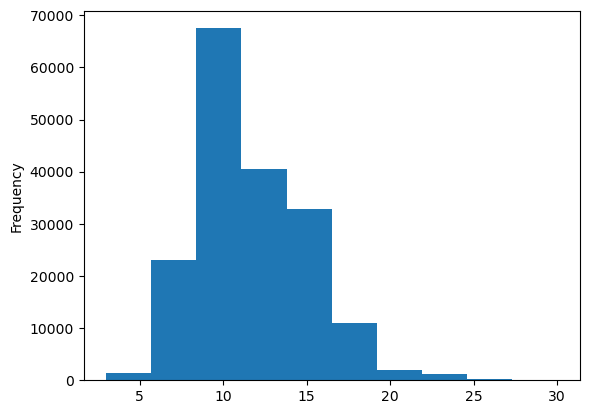

In [11]:
train_df.total_lines.plot.hist();

### Get list of sentences

Can get a list of sentences form the DataFrame by calling the `tolist()` method on the `'text'` column.

In [12]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# Veiw the first 10 lines of the training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

* Use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes to transform labels (the different role types) into numbers.

### One hot encode labels

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check training labels
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [15]:
# Extract the labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check the training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Create a series of model experiments

### Model 0: Getting a baseline

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded);

In [18]:
# Evaluate the baseline on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [19]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

#### Evaluation metrics
* Accuracy - the percent of sentences correctly classified
* Precision - the percent of true role predictions out of all predictions
* Recall - the percent of true role predictions out of all true role instances
* F1 score - the harmonic mean of precision and recall

In [20]:
# Helper function to evaluate a model
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [21]:
# Calculate the baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepare data for deep sequence models

In [22]:
# Avarege sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

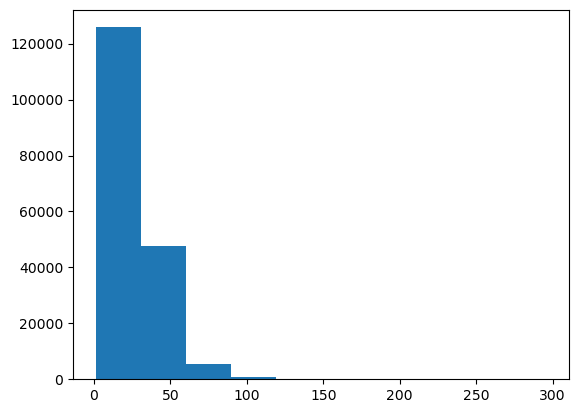

In [23]:
plt.hist(sent_lens, bins=10);

In [24]:
output_seq_len = int(np.percentile(sent_lens, 95)) # 95% of sequences should be shorter than this length
output_seq_len

55

In [25]:
# maximum number of words in a sequence
max(sent_lens)

296

### Create text vectorizer

In [26]:
max_tokens = 68000

In [27]:
# from tensorflow.keras.layers import TextVectorization

# Create a text vectorizer layer
# text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
#                                     output_sequence_length=55)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len)

In [28]:
# train_dataset = (train_dataset.map(lambda x, y: (text_vectorizer(x), y)))

In [29]:
# Test text vectorizer on random sentences
import random

# Adapt the text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
at @ weeks of gestation , @ ( @ % ) women were classified as emotional eaters , @ ( @ % ) as external eaters and @ ( @ % ) as restrained eaters .

Length of text: 36

Vectorized text:
[[   15    53     4  1443    90     9  2102    25  1413 15020    25  1489
  15020     3    25 21919 15020     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [30]:
# Number of words in the vocabulary
rct_20k_text_vocb = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabu;ary: {len(rct_20k_text_vocb)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocb[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocb[-5:]}")

Number of words in vocabu;ary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [31]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [32]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocb),# length of the vocabulary
                               output_dim=128,
                               mask_zero=True, # use masking to handle variable sequence lengths
                               name="token_embedding")

# example of token embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
at @ weeks of gestation , @ ( @ % ) women were classified as emotional eaters , @ ( @ % ) as external eaters and @ ( @ % ) as restrained eaters .

Sentence after vectorization (before embedding):
 [[   15    53     4  1443    90     9  2102    25  1413 15020    25  1489
  15020     3    25 21919 15020     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01276223 -0.00749974 -0.02712342 ... -0.01898676 -0.01900991
   -0.03605894]
  [ 0.00359537  0.04771153 -0.00643243 ... -0.01527812 -0.0119317
   -0.02938175]
  [ 0.0169819   0.03483384  0.03124685 ...  0.04920616 -0.02795278
    0.04448627]
  ...
  [-0.02169852  0.03183036  0.01232423 ... -0.00262802 -0.03790481
    0.04838889]
  [-0.02169852  0.03183036  0.01232423 ... -0.00262802 -0.03790481

### Create datasets (inputs and targets) for deep sequence models

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_encoded))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [34]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model 1: Conv1D with token embeddings

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

In [35]:
# # Create 1D convolutional model to process sequences
# inputs = layers.Input(shape=(1,), dtype=tf.string)
# text_vectors = text_vectorizer(inputs)
# token_embeddings = token_embed(text_vectors)
# x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)
# model_1 = tf.keras.Model(inputs, outputs)

# # Compile the model
# model_1.compile(loss="categorical_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accracy"])

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [37]:
# Preprocess the training dataset by applying one-hot encoding
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# Preprocess the validation dataset by applying one-hot encoding
valid_dataset = valid_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# Fit the model with preprocessed datasets
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),  # only fit on 10% of batches
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 12s 12ms/step - loss: 0.9252 - accuracy: 0.6332 - val_loss: 0.6853 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6590 - accuracy: 0.7563 - val_loss: 0.6270 - val_accuracy: 0.7726
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6186 - accuracy: 0.7738 - val_loss: 0.5969 - val_accuracy: 0.7859


In [39]:
# Fit the model
# model_1_history = model_1.fit(train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))),
#                               steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
#                               epochs=3,
#                               validation_data=valid_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))),
#                               validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches
# model_1_history = model_1.fit(train_dataset,
#                               steps_per_epoch=int(0.1 * len(train_dataset)),
#                               epochs=3,
#                               validation_data=valid_dataset,
#                               validation_steps=int(0.1 * len(valid_dataset)))

In [40]:
# Evaluate the data
model_1.evaluate(valid_dataset)


945/945 [==============================] - 6s 6ms/step - loss: 0.5989 - accuracy: 0.7856


[0.5988991856575012, 0.7856481075286865]

In [41]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.0590879e-01, 1.8631808e-01, 8.3553538e-02, 2.9013267e-01,
        3.4086905e-02],
       [4.5049539e-01, 2.2682874e-01, 1.0897840e-02, 3.0601332e-01,
        5.7647019e-03],
       [1.6243978e-01, 8.2886862e-03, 1.6161182e-03, 8.2760090e-01,
        5.4590429e-05],
       ...,
       [3.2637324e-06, 5.9843209e-04, 5.0773280e-04, 2.0319433e-06,
        9.9888855e-01],
       [6.0691774e-02, 4.2431560e-01, 1.1564250e-01, 6.6584036e-02,
        3.3276612e-01],
       [1.7372678e-01, 6.4728868e-01, 5.6867190e-02, 3.7043057e-02,
        8.5074328e-02]], dtype=float32)

In [42]:
# Convert the prediction probabilities to class labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [44]:
# Calculate the model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.56480868529061,
 'precision': 0.7821564725958795,
 'recall': 0.7856480868529061,
 'f1': 0.7832661306998852}